<a href="https://colab.research.google.com/github/angelh-16/nhanes_inferential_2021_23/blob/main/nhanes_inferential_2021_23_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install packages

In [ ]:
# Install packages

!pip install pyreadstat

import pandas as pd
import pyreadstat
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.9 MB/s eta 0:00:00


Download and convert XPT files to CSV

In [ ]:
# Downloaded XPT files to this folder
data_folder = "/content/data"

# Folder for save CSVs
csv_folder = "/content/csv"

# List of NHANES XPT files
xpt_files = [
    "BPXO_L.XPT",
    "DEMO_L.XPT",
    "HEPB_S_L.XPT",
    "KIQ_U_L.XPT",
    "PAQ_L.XPT",
    "VID_L.XPT",
    "WHQ_L.XPT"
]

# Loop through all XPT files in folder
for file in xpt_files:
    xpt_path = os.path.join(data_folder, file)
    csv_path = os.path.join(csv_folder, file.replace(".XPT", ".csv"))
    try:
        # Read the XPT file using latin1 encoding
        df, meta = pyreadstat.read_xport(xpt_path, encoding="latin1")
        # Save as CSV
        df.to_csv(csv_path, index=False)
        print(f"Converted {file} to {os.path.basename(csv_path)}")
    except Exception as e:
        print(f"Failed to {file}: {e}")

Converted BPXO_L.XPT to BPXO_L.csv
Converted DEMO_L.XPT to DEMO_L.csv
Converted HEPB_S_L.XPT to HEPB_S_L.csv
Converted KIQ_U_L.XPT to KIQ_U_L.csv
Converted PAQ_L.XPT to PAQ_L.csv
Converted VID_L.XPT to VID_L.csv
Converted WHQ_L.XPT to WHQ_L.csv


In [ ]:
# Load CSV into a dataframe
bpxo = pd.read_csv("/content/csv/BPXO_L.csv")
demo = pd.read_csv("/content/csv/DEMO_L.csv")
hepb = pd.read_csv("/content/csv/HEPB_S_L.csv")
kiq = pd.read_csv("/content/csv/KIQ_U_L.csv")
paq = pd.read_csv("/content/csv/PAQ_L.csv")
vid = pd.read_csv("/content/csv/VID_L.csv")
whq = pd.read_csv("/content/csv/WHQ_L.csv")

In [ ]:
# Confirm load successful
for name, df_ in [
    ('BPXO', bpxo),
    ('DEMO', demo),
    ('HEPB', hepb),
    ('KIQ', kiq),
    ('PAQ', paq),
    ('VID', vid),
    ('WHQ', whq)
    ]:
    print(f"{name:5s} : {df_.shape} ")


BPXO  : (7801, 12) 
DEMO  : (11933, 27) 
HEPB  : (8611, 3) 
KIQ   : (7809, 9) 
PAQ   : (8153, 8) 
VID   : (8727, 10) 
WHQ   : (8501, 5) 


Data clean up & recoding

In [ ]:
# Replaces the placeholder values 7777 and 9999
def clean_placeholder(series):
    return series.replace({7777: np.nan, 9999: np.nan})

In [ ]:
# Make copies of dataframes so original not modified
bpxo = bpxo.copy();
demo = demo.copy();
hepb = hepb.copy();
kiq = kiq.copy();
paq = paq.copy();
vid = vid.copy();
whq = whq.copy();

In [ ]:
# Marital Status (DMDMARTZ) - categorical, needs recoding (married or not married)
def recode_married(x):
    if pd.isna(x) or x in [77, 99]:
        return np.nan  # Missing/Refused/Don't know
    elif x == 1:
        return 1  # Married/Living with partner
    else:
        return 0  # Widowed/Divorced/Separated/Never married
demo['married'] = demo['DMDMARTZ'].apply(recode_married) if 'DMDMARTZ' in demo else np.nan

# Education Level (DMDEDUC2) - categorical, needs recoding (bachelor’s or higher vs. less than bachelor’s)
def recode_educ(x):
    if pd.isna(x) or x in [7, 9]:
        return np.nan  # Missing/refused/don't know
    elif x == 5:
        return 1  # Bachelor’s or higher
    else:
        return 0  # Less than bachelor’s
demo['education'] = demo['DMDEDUC2'].apply(recode_educ) if 'DMDEDUC2' in demo else np.nan

# Age in Years (RIDAGEYR) - continuous
def clean_age(x):
    if pd.isna(x):
        return np.nan
    try:
        x = int(x)
    except:
        return np.nan
    if 0 <= x <= 79:
        return x
    elif x == 80:
        return "80+"  # 80 years of age and over
    else:
        return np.nan
demo['age'] = demo['RIDAGEYR'].apply(clean_age) if 'RIDAGEYR' in demo else np.nan

# Systolic Blood Pressure (BPXOSY3) - continuous
# Diastolic Blood Pressure (BPXODI3) - continuous
for col in ['BPXOSY3', 'BPXODI3']:
    if col in bpxo:
        bpxo[col] = clean_placeholder(bpxo[col])

# Vitamin D Lab Interpretation (LBDVD2LC) - categorical, two levels
def recode_vitd(x):
    if pd.isna(x):
        return np.nan
    elif x == 1:
        return "Deficient"  #	Below lower detection limit
    elif x == 0:
        return "Sufficient"  # At or above the detection limit
    else:
        return np.nan
vid['vitd_status'] = vid['LBDVD2LC'].apply(recode_vitd) if 'LBDVD2LC' in vid else np.nan

# Hepatitis B Lab Antibodies (LBXHBS) - categorical, needs recoding to two levels
def recode_hbs(x):
    if pd.isna(x):
        return np.nan
    elif x == 1:
        return "Positive"  # Positive
    elif x == 2:
        return "Negative"  # Negative
    else:
        return np.nan
hepb['hbs_status'] = hepb['LBXHBS'].apply(recode_hbs) if 'LBXHBS' in hepb else np.nan

# Weak/Failing Kidneys (KIQ022) - categorical, can be treated as two levels
if 'KIQ022' in kiq:
    kiq['KIQ022'] = clean_placeholder(kiq['KIQ022'])
def recode_kidney(x):
    if pd.isna(x):
        return np.nan
    elif x == 1:
        return "Yes"  # Yes
    elif x == 2:
        return "No"  # No
    else:
        return np.nan
kiq['kidney_problem'] = kiq['KIQ022'].apply(recode_kidney) if 'KIQ022' in demo else np.nan

# Minutes of Sedentary Behavior (PAD680) - continuous, needs cleaning (remove values 7777, 9999, and null)
if 'PAD680' in paq:
    paq['PAD680'] = clean_placeholder(paq['PAD680'])

# Current Self-Reported Weight (WHD020) - continuous, needs cleaning (remove values 7777, 9999, and null)
if 'WHD020' in whq:
    whq['WHD020'] = clean_placeholder(whq['WHD020'])

Merge datasets and check

In [ ]:
# Start with DEMO as base
merged = demo.copy()

# Add datasets to DEMO
for df in [bpxo, paq, whq, vid, hepb, kiq]:
    merged = pd.merge(merged, df, on='SEQN', how='left')

# Check shape
print(merged.shape)
merged.head()

# Check missing values
print(merged.isna().sum().sort_values(ascending=False).head(10))


# Check value counts for categorical recodes
for col in ['married', 'education', 'vitd_status', 'hbs_status', 'kidney_problem']:
    if col in merged:
        print(f"\n{col} value counts:\n", merged[col].value_counts(dropna=False))
# Check
print('\nContinuous checks:')
print(merged[['RIDAGEYR','PAD680','WHD020','BPXOSY3']].describe())

(11933, 74)
kidney_problem    11933
KIQ025            11612
RIDAGEMN          11556
RIDEXPRG          10430
DMDYRUSR          10058
DMDHSEDZ           9806
KIQ010             9609
KIQ052             9390
RIDEXAGM           9146
PAD810U            8247
dtype: int64

married value counts:
 married
NaN    4150
1.0    4136
0.0    3647
Name: count, dtype: int64

education value counts:
 education
0.0    5158
NaN    4150
1.0    2625
Name: count, dtype: int64

vitd_status value counts:
 vitd_status
Deficient     5860
NaN           4626
Sufficient    1447
Name: count, dtype: int64

hbs_status value counts:
 hbs_status
Negative    5324
NaN         4567
Positive    2042
Name: count, dtype: int64

kidney_problem value counts:
 kidney_problem
NaN    11933
Name: count, dtype: int64

Continuous checks:
           RIDAGEYR       PAD680       WHD020      BPXOSY3
count  11933.000000  8065.000000  8358.000000  7480.000000
mean      38.317858   362.176069   179.502273   118.917647
std       25.601990   2

 - **Question 1**: "Is there **an association** between marital status (married or not married) and education level (bachelor’s degree or higher vs. less than a bachelor’s degree)?"  
     - Variables: `DMDMARTZ` (marital status) and `DMDEDUC2` (education level). Recode as specified.

In [ ]:
# Merge varibles together and drop missing values
q1 = merged[['married','education']].dropna()

# Create contingency table
table = pd.crosstab(q1['married'], q1['education'])

# Rename table rows and columns
table = table.rename(index={0: 'Not married', 1: 'Married'},
               columns={0: 'Less than bachelor', 1: 'Bachelor or higher'})

# Conduct Chi-square test to see association
chi2, p, dof, exp = stats.chi2_contingency(table)

# Display table
print(table)
print()

print(f"Chi-square statistic = {chi2:.3f}")
print(f"Degrees of freedom = {dof}")
print(f"P-value = {p:.4g}")
print(f"Sample size (n) = {len(q1)}")

# Results
if p < 0.05:
    print("\nResult: There is an association between marital status and education level (p < 0.05).")
else:
    print("\nResult: There is no association between marital status and education level (p ≥ 0.05).")

education    Less than bachelor  Bachelor or higher
married                                            
Not married                2648                 990
Married                    2503                1631

Chi-square statistic = 129.174
Degrees of freedom = 1
P-value = 6.213e-30
Sample size (n) = 7772

Result: There is an association between marital status and education level (p < 0.05).


- **Question 2**: "Is there a difference in the mean sedentary behavior time between those who are married and those who are not married?"  
     - Variables: `DMDMARTZ` (marital status, recoded) and `PAD680` (sedentary behavior time, cleaned).

         count     mean      std
married                         
0.0       3603  371.958  219.533
1.0       4106  353.287  203.885
t-test: t=3.851, p=0.0001184



/tmp/ipython-input-2365977746.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


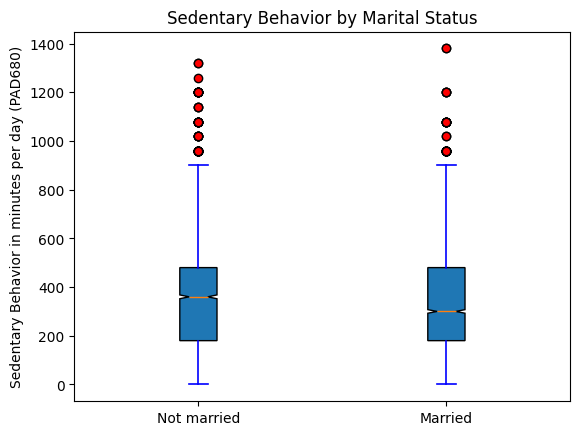


Result: There is a difference in the mean sedentary behavior time between those who are married and those who are not married (p < 0.05).


In [ ]:
# Merge varibles together and drop missing values
q2 = merged[['married','PAD680']].dropna()

# Create a table with two varibles
table = q2.groupby('married')['PAD680'].agg(['count','mean','std']).round(3)
mar0 = q2.loc[q2['married'] == 0, 'PAD680']  # Not married
mar1 = q2.loc[q2['married'] == 1, 'PAD680']  # Married

# Conduct t test
t, p = stats.ttest_ind(mar0, mar1, equal_var=False)
print(table)
print(f"t-test: t={t:.3f}, p={p:.4g}")
print()

# Generate boxplot
plt.figure()
box = plt.boxplot(
    [mar0.values, mar1.values],
    labels=['Not married', 'Married'],
    notch=True,
    patch_artist=True,  # allows coloring,
    whiskerprops=dict(color='blue', linewidth=1.2),
    capprops=dict(color='blue', linewidth=1.2),
    flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
)
plt.ylabel('Sedentary Behavior in minutes per day (PAD680)')
plt.title('Sedentary Behavior by Marital Status')
plt.show()

# Results
if p < 0.05:
    print("\nResult: There is a difference in the mean sedentary behavior time between those who are married and those who are not married (p < 0.05).")
else:
    print("\nResult: There is no difference in the mean sedentary behavior time between those who are married and those who are not married (p ≥ 0.05).")

   - **Question 3**: "How do age and marital status affect systolic blood pressure?"  
     - Variables: `RIDAGEYR` (age), `DMDMARTZ` (marital status, recoded), and `BPXOSY3` (systolic blood pressure).

                            OLS Regression Results                            
Dep. Variable:                BPXOSY3   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     453.3
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          1.00e-183
Time:                        05:12:33   Log-Likelihood:                -24856.
No. Observations:                5838   AIC:                         4.972e+04
Df Residuals:                    5835   BIC:                         4.974e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    102.1600      0.764    133.758      0.0

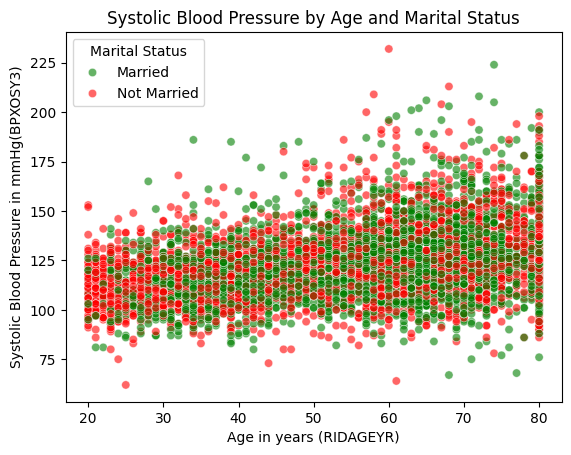

Result is statistically significant(p < 0.05).


In [ ]:
# Merge varibles together and drop missing values
q3 = merged[['BPXOSY3','RIDAGEYR','married']].dropna()
q3['marital_binary'] = q3['married'].apply(lambda x: 'Married' if x==1 else 'Not Married')

# Fit linear regression
model = smf.ols('BPXOSY3 ~ RIDAGEYR + married', data=q3).fit()

# Regression summary
print(model.summary())

# Scatter plot
plt.figure()
sns.scatterplot(
    data=q3,
    x='RIDAGEYR',
    y='BPXOSY3',
    hue='marital_binary',
    alpha=0.6,
    palette={'Married':'green', 'Not Married':'red'}
)

plt.title('Systolic Blood Pressure by Age and Marital Status')
plt.xlabel('Age in years (RIDAGEYR)')
plt.ylabel('Systolic Blood Pressure in mmHg(BPXOSY3)')
plt.legend(title='Marital Status')
plt.show()

# Results
if p < 0.05:
    print("Result is statistically significant(p < 0.05).")
else:
    print("Result is not statistically significant (p ≥ 0.05).")


   - **Question 4**: "Is there a **correlation** between self-reported weight and minutes of sedentary behavior?"  
     - Variables: `WHD020` (self-reported weight, cleaned) and `PAD680` (sedentary behavior time, cleaned).

Pearson r=0.156, p=1.699e-44


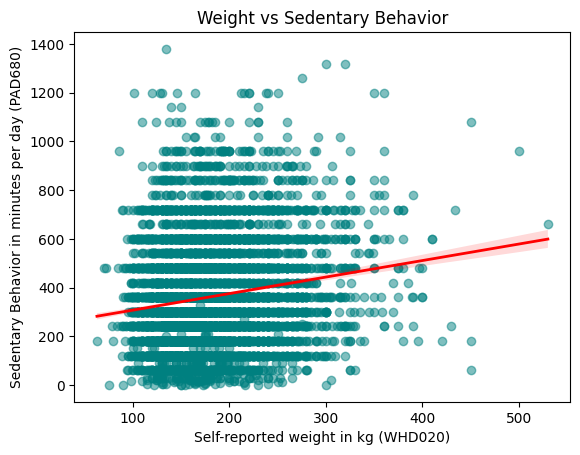


Result: There is a correlation between self-reported weight and minutes of sedentary behavior (p < 0.05).
Correlation strength: weak


In [ ]:
# Merge varibles together and drop missing values
q4 = merged[['WHD020','PAD680']].dropna()

#Conduct pearson correlation
r , p = stats.pearsonr(q4['WHD020'], q4['PAD680'])
print(f'Pearson r={r:.3f}, p={p:.4g}')

# Scatter plot
plt.figure()
sns.regplot(
    data=q4,
    x='WHD020',
    y='PAD680',
    scatter_kws={'alpha':0.5, 'color':'teal'},
    line_kws={'color':'red', 'linewidth':2}
)

plt.xlabel('Self-reported weight in kg (WHD020)')
plt.ylabel('Sedentary Behavior in minutes per day (PAD680)')
plt.title('Weight vs Sedentary Behavior')
plt.show()

# Results
if p < 0.05:
    print("\nResult: There is a correlation between self-reported weight and minutes of sedentary behavior (p < 0.05).")
else:
    print("\nResult: There is no correlation between self-reported weight and minutes of sedentary behavior (p ≥ 0.05).")
print(f"Correlation strength: {'weak' if abs(r)<0.3 else 'moderate' if abs(r)<0.5 else 'strong'}")

   - **Question 5 (Creative Analysis)**: Develop your own unique question using at least one of the variables listed above. Ensure that your question can be answered using one of the following tests: chi-square, t-test, ANOVA, or correlation. Clearly state your question, explain why you chose the test, and document your findings.

   -"Is there an association between education level and being overweight?"
     - Variables: `DMDEDUC2 ` (education level) and `WHD020` (self-reported weight, cleaned).
   


In [ ]:
# Merge varibles together and drop missing values
q5 = merged[['WHD020','education']].dropna()
q5['overweight'] = q5['WHD020'].apply(lambda x: 'Overweight' if x >= 80 else 'Not Overweight')

# Create contingency table
table = pd.crosstab(q5['education'], q5['overweight'])

# Rename table rows and columns
table = table.rename(index={0: 'Less than bachelor', 1: 'Bachelor or higher'},
               columns={0: 'Not Overweight', 1: 'Overweight'})

# Conduct Chi-square test to see association
chi2, p, dof, expected = stats.chi2_contingency(table)

# Display table
print(table)
print()
print(f"Chi-square statistic = {chi2:.3f}")
print(f"Degrees of freedom = {dof}")
print(f"P-value = {p:.4g}")
print(f"Sample size (n) = {len(q1)}")

# Results
if p < 0.05:
    print("\nResult: There is an association between education level and overweight status (p < 0.05).")
else:
    print("\nResult: There is no association between education level and overweight status (p ≥ 0.05).")


overweight          Not Overweight  Overweight
education                                     
Less than bachelor               5        5072
Bachelor or higher               0        2599

Chi-square statistic = 1.272
Degrees of freedom = 1
P-value = 0.2594
Sample size (n) = 7772

Result: There is no association between education level and overweight status (p ≥ 0.05).
